## Paper Appendix example (final implementaton afterwards)

In [158]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

As it is in the paper, but transposed cause sklearn uses rows for true and columns for predicted

In [159]:
cm = np.array([
    [ 5,  5,  7],  # negA
    [ 1, 50,  8],  # neuA
    [ 4,  5, 15],  # posA
]).T

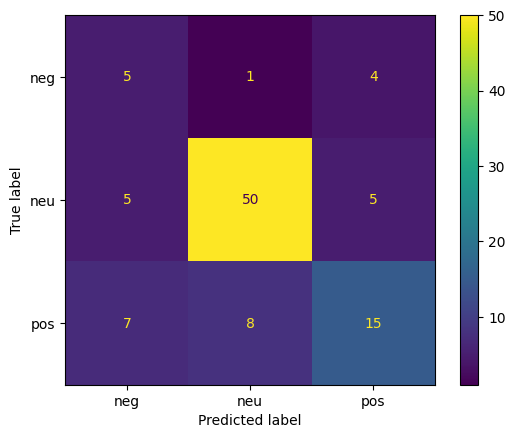

In [160]:
ConfusionMatrixDisplay(cm, display_labels=['neg', 'neu', 'pos']).plot()

In [161]:
freq = cm.sum(axis=1) 
p = np.concatenate(([0], np.cumsum(freq)))
r = np.concatenate(([0], np.cumsum(freq[::-1])))

Gold proximity weight matrix

In [180]:
N = len(freq)
i, j = np.indices((N, N))

above = (freq[i] / 2.0) + (p[j + 1] - p[i + 1])  # i <= j
# I'm sure there's a more elegant way of addressing the lower triangle indices
below = (freq[i] / 2.0) + (r[N - j] - r[N - i])  # i > j

numerator = np.where(i <= j, above, below)

total = freq.sum()
fraction = numerator / total

epsilon = 1e-12 # log(0) safeguard *facepalm*
proximity_matrix = -np.log2(np.clip(fraction, epsilon, float('inf')))


In [163]:
# to match with the gold columns, as sklearn confusion matrix is transposed
proximity_matrix = proximity_matrix.T

Global computation

In [165]:
(cm * proximity_matrix).sum() / (freq * proximity_matrix.diagonal()).sum()

0.7117023174151088

## Implementation

In [173]:
import pandas as pd
import numpy as np

from pandas import Series # for typing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [174]:
gold = pd.read_table('../data/gold_paper_a.tsv', header=None, names=['topic', 'id', 'gold'])
pred = pd.read_table('../data/sys_paper_a.tsv', header=None, names=['topic', 'id', 'pred'])

df = pd.merge(gold, pred, on=['topic', 'id'])
df = df.dropna()

In [175]:
df['gold'] = df['gold'].astype(str)
df['pred'] = df['pred'].astype(str)
sorted_labels = ['-1', '0', '1'] # order is preserved in the confusion matrix

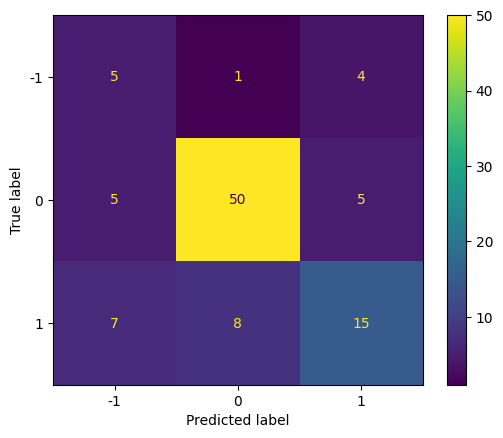

In [176]:
cm = confusion_matrix(df['gold'], df['pred'], labels=sorted_labels)
ConfusionMatrixDisplay(cm, display_labels=sorted_labels).plot()

In [177]:
# This is the good stuff
def evaluate(gold: Series, pred: Series, sorted_labels: list) -> float:
    cm = confusion_matrix(gold, pred, labels=sorted_labels)

    # Gold frequency and prefix sum
    freq = cm.sum(axis=1)
    p = np.concatenate(([0], np.cumsum(freq))) 
    r = np.concatenate(([0], np.cumsum(freq[::-1])))
    
    N = len(freq)
    i, j = np.indices((N, N))

    # Gold proximity matrix
    above = (freq[i] / 2.0) + (p[j + 1] - p[i + 1])  # i <= j
    below = (freq[i] / 2.0) + (r[N - j] - r[N - i])  # i > j

    numerator = np.where(i <= j, above, below)

    total = freq.sum()
    fraction = numerator / total

    epsilon = 1e-12 # log(0) safeguard *facepalm*
    proximity_matrix = -np.log2(np.clip(fraction, epsilon, 1.0)).T

    result = (cm * proximity_matrix).sum() / (freq * proximity_matrix.diagonal()).sum()
    return result.sum()

In [178]:
results = []
for topic in df['topic'].unique():
    value = evaluate(
        gold=df[df['topic'] == topic]['gold'], 
        pred=df[df['topic'] == topic]['pred'], 
        sorted_labels=sorted_labels
    )
    results.append({'topic': topic, 'value': value})

pd.DataFrame(results)

,topic,value
0,test,0.711702
